In [22]:
import matplotlib.pyplot as plt
import scipy.optimize as fit
import numpy as np

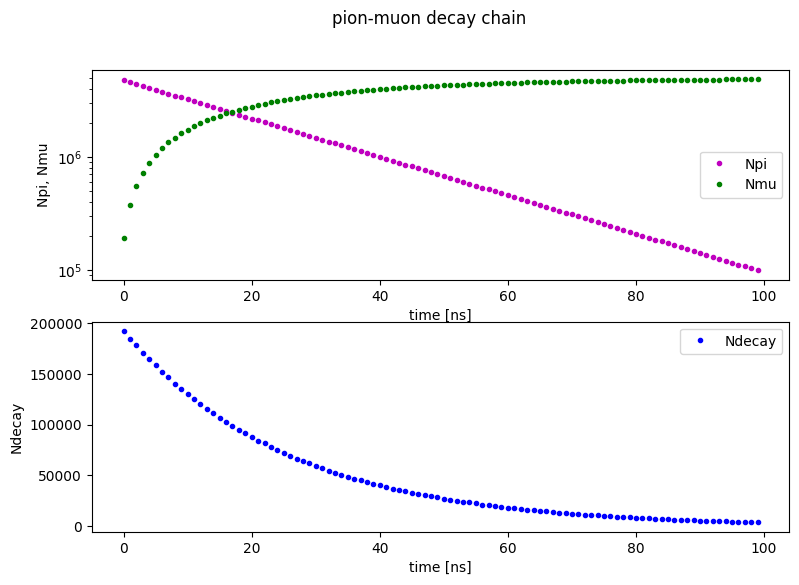

In [23]:
# illustrates pitfalls in fitting data with low statistics, i.e. sqrt(N) issues

tau = 26.0             # lifetime of charged pion (ns)

dt = 0.1               # time bin size
N = 1000               # time bin number
T = N*dt               # time bin range

prob = dt/tau          # decay probability in interval dt

Npi = 5000000          # initial conditions, # of pi's (do 1000, 10000, 10000)
Nmu = 0                # initial conditions, # of mu's
np.random.seed(12345)  # seed for RNG

Nmin, Nmax = 0,399     # bin range for least squares

def fdy(t, p1, p2):    # fit function for least squares
    return p1*np.exp(-t/p2)

time = np.arange( 0.0, N*dt, dt, dtype=float) # define time array
Npidata = np.zeros( N, dtype=int)  # initialize pion population array
Nmudata = np.zeros( N, dtype=int)  # initialize muon population array
Ndydata = np.zeros( N, dtype=int)  # initial measured decay's array

for it in range(N): # loop over time steps
    Ndy = 0
    for ip in range(Npi): # loop over surviving pions
        if np.random.ranf() < prob:
            Ndy += 1

    Npi -= Ndy
    Nmu += Ndy

    Npidata[it] = Npi # pion population at time it
    Nmudata[it] = Nmu # muon population at time it
    Ndydata[it] = Ndy # measured decay at time it

time_filter = time[ Ndydata != 0 ] # filter to remove points with Ndy = 0's
Ndydata_filter = Ndydata[ Ndydata != 0 ]  # filter to remove points with Ndy = 0's

fig, axes = plt.subplots(2,figsize=(9, 6))
fig.suptitle('pion-muon decay chain')

axes[0].plot(time,Npidata,"m.",label="Npi")
axes[0].plot(time,Nmudata,"g.",label="Nmu")
axes[0].set_xlabel("time [ns]")
axes[0].set_ylabel("Npi, Nmu")
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(time,Ndydata,"b.",label="Ndecay")
#axes[1].plot(time_filter,Ndydata_filter,"m.",label="Ndecay")
axes[1].set_xlabel("time [ns]")
axes[1].set_ylabel("Ndecay")
#axes[1].set_yscale('log') # don't see 0's
axes[1].legend()


tau_pi 25.51 +/-  0.00 ns
chi2 4408312.51, chi2/ndf 44982.78


Text(0, 0.5, 'Ndecay')

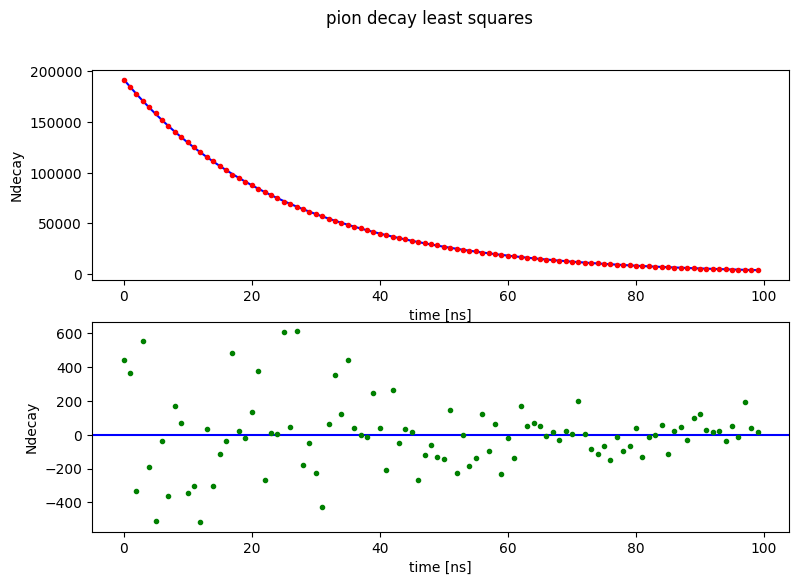

In [24]:
# fit with equal uncertainties

pars, covs = fit.curve_fit( fdy, time[Nmin:Nmax],  Ndydata[Nmin:Nmax], p0=[Npi,25.], absolute_sigma=True)
# args: callable function, x, y, parameter guesses

Nfit = fdy( time, pars[0], pars[1])     # fit function
residuals = Nfit - Ndydata              # fit residuals
chi2 = np.sum( residuals**2)            # chi-squared
chi2pdf = chi2/(len(time[Nmin:Nmax])-2) # chi^2 / pdf

print( "tau_pi %5.2f +/- %5.2f" % (pars[1], np.sqrt(covs[1][1])),"ns") # fit results
print( "chi2 %5.2f, chi2/ndf %5.2f" % (chi2, chi2pdf))                 # fit results

fig, axes = plt.subplots(2,figsize=(9, 6))
fig.suptitle('pion decay least squares')

axes[0].errorbar(time, Ndydata,yerr=1, fmt="r.")
axes[0].plot(time,Nfit,"b-")
axes[0].set_xlabel("time [ns]")
axes[0].set_ylabel("Ndecay")
#axes[0].set_yscale('log')

axes[1].errorbar(time, residuals, yerr=1, fmt="g.")
axes[1].axhline( y=0.0, color='b', linestyle='-')
axes[1].set_xlabel("time [ns]")
axes[1].set_ylabel("Ndecay")

tau_pi 25.51 +/-  0.01 ns
chi2 90.04, chi2/ndf  0.92


Text(0, 0.5, 'Ndecay')

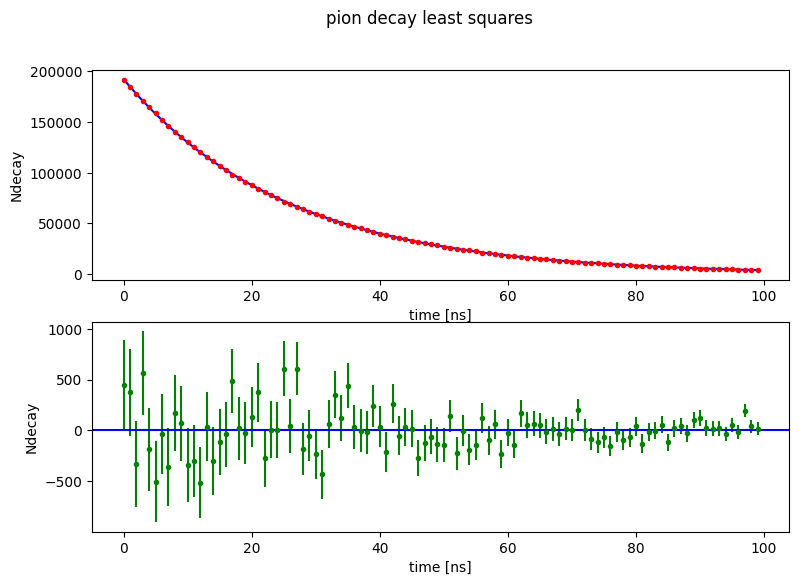

In [25]:
# fit with sqrt(N) uncertainties

#s = np.sqrt(Ndydata)
#pars, covs = fit.curve_fit( fdy, time[Nmin:Nmax],  Ndydata[Nmin:Nmax], p0=[Npi,25.], sigma=s[Nmin:Nmax], absolute_sigma=True)

s = np.sqrt(Ndydata)+1 # note ugly fix for zero counts -> bias
pars, covs = fit.curve_fit( fdy, time[Nmin:Nmax],  Ndydata[Nmin:Nmax], p0=[Npi,25.], sigma=s[Nmin:Nmax], absolute_sigma=True)

#s_filter = s[ Ndydata != 0 ] # ugly filter to remove points with Ndy = 0's -> bias
#pars, covs = fit.curve_fit( fdy, time_filter,  Ndydata_filter, p0=[Npi,25.], sigma=s_filter, absolute_sigma=True)

Nfit = fdy(time, pars[0], pars[1])
residuals = (Nfit - Ndydata)
chi2 = np.sum(residuals[Nmin:Nmax]**2/s[Nmin:Nmax]**2)
chi2pdf = chi2/(len(time[Nmin:Nmax])-2)

print( "tau_pi %5.2f +/- %5.2f" % (pars[1], np.sqrt(covs[1][1])),"ns")
print( "chi2 %5.2f, chi2/ndf %5.2f" % (chi2, chi2pdf))

fig, axes = plt.subplots(2,figsize=(9, 6))
fig.suptitle('pion decay least squares')

axes[0].errorbar(time, Ndydata, yerr=s, fmt="r.")
axes[0].plot(time,Nfit,"b-")
axes[0].set_xlabel("time [ns]")
axes[0].set_ylabel("Ndecay")
#axes[0].set_yscale('log')

axes[1].errorbar(time, residuals, yerr=s, fmt="g.")
axes[1].axhline( y=0.0, color='b', linestyle='-')
axes[1].set_xlabel("time [ns]")
axes[1].set_ylabel("Ndecay")

tau_pi 25.51 +/-  0.01 ns
chi2 90.86, chi2/ndf  0.93


Text(0, 0.5, 'Ndecay')

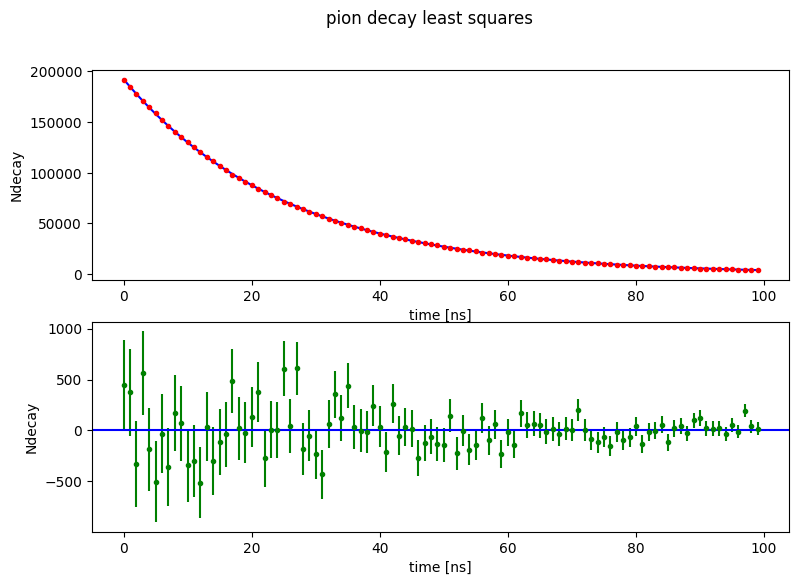

In [26]:
# fit with sqrt(Nfit) uncertainties

s = np.sqrt(Nfit)
pars, covs = fit.curve_fit( fdy, time[Nmin:Nmax],  Ndydata[Nmin:Nmax], p0=[Npi,25.], sigma=s[Nmin:Nmax], absolute_sigma=True)

Nfit = fdy(time, pars[0], pars[1])
residuals = (Nfit - Ndydata)
chi2 = np.sum(residuals[Nmin:Nmax]**2/s[Nmin:Nmax]**2)
chi2pdf = chi2/(len(time[Nmin:Nmax])-2)

print( "tau_pi %5.2f +/- %5.2f" % (pars[1], np.sqrt(covs[1][1])),"ns")
print( "chi2 %5.2f, chi2/ndf %5.2f" % (chi2, chi2pdf))

fig, axes = plt.subplots(2,figsize=(9, 6))
fig.suptitle('pion decay least squares')

axes[0].errorbar(time, Ndydata, yerr=s, fmt="r.")
axes[0].plot(time,Nfit,"b-")
axes[0].set_xlabel("time [ns]")
axes[0].set_ylabel("Ndecay")
#axes[0].set_yscale('log')

axes[1].errorbar(time, residuals, yerr=s, fmt="g.")
axes[1].axhline( y=0.0, color='b', linestyle='-')
axes[1].set_xlabel("time [ns]")
axes[1].set_ylabel("Ndecay")

tau_pi 25.51 +/-  0.01
chi2 90.86, chi2/ndf  0.93


Text(0, 0.5, 'Ndecay')

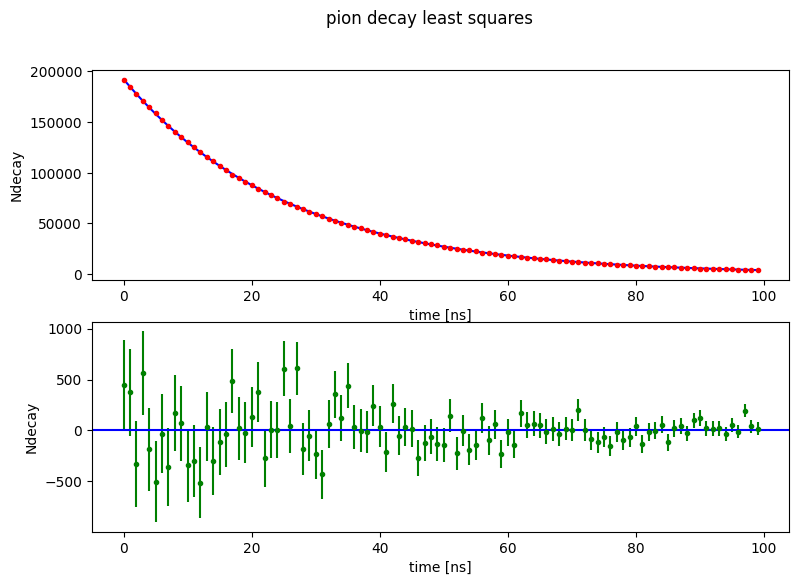

In [27]:
#fit with iterated sqrt(Nfit) uncertainties
s = np.sqrt(Nfit)
pars, covs = fit.curve_fit( fdy, time[Nmin:Nmax],  Ndydata[Nmin:Nmax], p0=[Npi,25.], sigma=s[Nmin:Nmax], absolute_sigma=True)

Nfit = fdy(time, pars[0], pars[1])
residuals = (Nfit - Ndydata)
chi2 = np.sum(residuals[Nmin:Nmax]**2/s[Nmin:Nmax]**2)
chi2pdf = chi2/(len(time[Nmin:Nmax])-2)

print( "tau_pi %5.2f +/- %5.2f" % (pars[1], np.sqrt(covs[1][1])))
print( "chi2 %5.2f, chi2/ndf %5.2f" % (chi2, chi2pdf))

fig, axes = plt.subplots(2,figsize=(9, 6))
fig.suptitle('pion decay least squares')

axes[0].errorbar(time, Ndydata, yerr=s, fmt="r.")
axes[0].plot(time,Nfit,"b-")
axes[0].set_xlabel("time [ns]")
axes[0].set_ylabel("Ndecay")
#axes[0].set_yscale('log')

axes[1].errorbar(time, residuals, yerr=s, fmt="g.")
axes[1].axhline( y=0.0, color='b', linestyle='-')
axes[1].set_xlabel("time [ns]")
axes[1].set_ylabel("Ndecay")